**This notebook compute the active subspace of the Neural Network trained on MNIST dataset.**

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from tqdm import tqdm_notebook as tqdm

from nnsubspace.nndataset.dataset import Dataset
from nnsubspace.nnmodel.model import NNModel
from nnsubspace.nnsubspace.subspace import NNSubspace
import nnsubspace.visual.subspaceplot as subspaceplot

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# center picture
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
# The package supports mnist/cifar10/cifar100/ImageNet, you can also add other datasets to the package
dataset_name = 'mnist'

dataset = Dataset(dataset_name=dataset_name)
model = NNModel(dataset_name=dataset_name, model_id='0')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


**Test single sample**

* sample number of 259 from the test dataset is presented in the paper

sample 259 | model prediction | ground truth
label: 6, score: 0.69
label: 6, score: 1.00


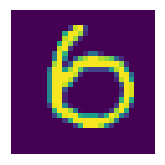

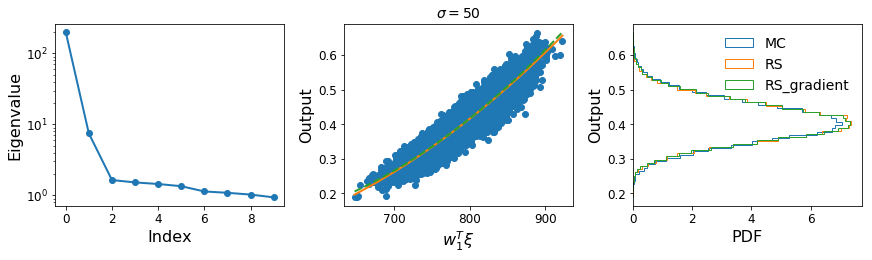

In [4]:
i_sample = 259
x = dataset.x_test[i_sample]
x = np.expand_dims(x, axis=0)
y = model.model.predict(x)
print('sample {} | model prediction | ground truth'.format(i_sample))
dataset.decode_predictions(y)
dataset.decode_predictions(dataset.y_test[i_sample])

subspaceplot.imshow(np.squeeze(x + dataset.x_train_mean), figsize=(2, 2))

AS = NNSubspace(model=model.model, x=x, x_train_mean=dataset.x_train_mean)

for sigma in np.array([50]):

  AS.sampling_setup(num_gradient_mc=1000,
                   num_rs_mc=50000,
                   seed=7,
                   bool_clip=True,
                   sigma=sigma / 255,
                   num_eigenvalue=10)
  AS.run()

  AS.threecolumnplot(title='$\sigma = $'+str(sigma))

**Bootstrapping**

In [5]:
import matplotlib.pyplot as plt

N_bootstrap = 10000

n_mc_list = np.logspace(1,np.log10(AS.num_rs_mc), num=50, base=10, dtype='int32')

mean_list = np.empty_like(n_mc_list, dtype='float32')
std_list = np.empty_like(n_mc_list, dtype='float32')

mean_list_boostrap = np.zeros(N_bootstrap, dtype='float32')

for index, n_mc in enumerate(n_mc_list):  
  for i_bootstrap in range(N_bootstrap):
    mean_list_boostrap[i_bootstrap] = np.mean(AS.y_samples_rs[np.random.choice(AS.num_rs_mc, n_mc, replace=True)])

  mean_list[index] = np.mean(mean_list_boostrap)
  std_list[index] = np.std(mean_list_boostrap)

n_mc_list_mc = np.copy(n_mc_list)
mean_list_mc = np.copy(mean_list)
std_list_mc = np.copy(std_list)

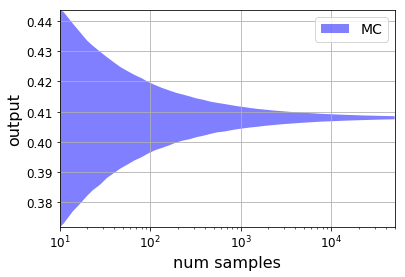

In [6]:
# plot it!
fig, ax = plt.subplots(1)

# ax.plot(n_mc_list, mean_list, lw=2, label='MC', color='blue')
ax.fill_between(n_mc_list, mean_list+std_list*2, mean_list-std_list*2, label='MC', facecolor='blue',alpha=0.5)

ax.set_xlim(n_mc_list.min(), n_mc_list.max())
ax.set_ylim(np.min(mean_list-std_list*2), np.max(mean_list+std_list*2) , AS.num_rs_mc)

ax.set_xscale('log')

ax.set_xlabel('num samples')
ax.set_ylabel('output')

ax.grid()
ax.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt

N_bootstrap = 500

n_mc_list = np.linspace(12, AS.num_gradient_mc, num=10, dtype='int32')

mean_list = np.empty_like(n_mc_list, dtype='float32')
std_list = np.empty_like(n_mc_list, dtype='float32')

mean_list_boostrap = np.zeros(N_bootstrap, dtype='float32')

# re-evaluate the gradients
# re-evaluate the response surface

for index, n_mc in enumerate(n_mc_list):
  print('Runing bootstrap for n_mc = {}'.format(n_mc))
  for i_bootstrap in tqdm(range(N_bootstrap)):
    AS.num_gradient_mc = n_mc
    
    gradient_index = np.random.choice(AS.num_rs_mc, AS.num_gradient_mc, replace=True)
    
    AS.x_samples_gradient = AS.x_samples_rs[gradient_index]
    AS.x_samples_gradient_flat = AS.x_samples_gradient.reshape(AS.num_gradient_mc, -1)
    
    AS.evaluate_gradient()
    AS.svd()
    
    AS.poly1d_gradient = np.poly1d(np.polyfit(AS.xv[gradient_index, 0], AS.y_samples_rs[gradient_index], 2))
    
    mean_list_boostrap[i_bootstrap] = np.mean(AS.poly1d_gradient(AS.xv[:, 0]))

  mean_list[index] = np.mean(mean_list_boostrap)
  std_list[index] = np.std(mean_list_boostrap)

n_mc_list_rs = np.copy(n_mc_list)
mean_list_rs = np.copy(mean_list)  
std_list_rs = np.copy(std_list)

Runing bootstrap for n_mc = 12


A Jupyter Widget

Runing bootstrap for n_mc = 12


A Jupyter Widget

Runing bootstrap for n_mc = 12


A Jupyter Widget

Runing bootstrap for n_mc = 12


A Jupyter Widget

Runing bootstrap for n_mc = 12


A Jupyter Widget

In [8]:
AS.num_gradient_mc

1000

In [ ]:
# plot it!
fig, ax = plt.subplots(1)

# ax.plot(n_mc_list, mean_list, lw=2, label='MC', color='blue')
ax.fill_between(n_mc_list, mean_list+std_list*2, mean_list-std_list*2, label='AS+RS', facecolor='blue',alpha=0.5)

ax.set_xlim(n_mc_list.min(), n_mc_list.max())
ax.set_ylim(np.min(mean_list-std_list*2), np.max(mean_list+std_list*2) , AS.num_rs_mc)

ax.set_xscale('log')

ax.set_xlabel('num samples')
ax.set_ylabel('output')

ax.grid()
ax.legend()

plt.show()

In [ ]:
# plot it!
fig, ax = plt.subplots(1)

# ax.plot(n_mc_list, mean_list, lw=2, label='MC', color='blue')
ax.fill_between(n_mc_list_mc, mean_list_mc+std_list_mc*2, mean_list_mc-std_list_mc*2, label='MC', facecolor='blue',alpha=0.5)
ax.fill_between(n_mc_list_rs, mean_list_rs+std_list_rs*2, mean_list_rs-std_list_rs*2, label='AS+RS', facecolor='red',alpha=0.5)

ax.set_xlim(n_mc_list_mc.min(), n_mc_list_mc.max())
ax.set_ylim(np.min(mean_list_mc-std_list_mc*2), np.max(mean_list_mc+std_list_mc*2) , AS.num_rs_mc)

ax.set_xscale('log')

ax.set_xlabel('num samples')
ax.set_ylabel('output')

ax.grid()
ax.legend()

plt.show()